# Overview
This notebook is a step by step to calculate the degrees from semi-circular trajectory data

## Steps
* grab the first point in the trajectory data 512 551 #(964, 480)
* reverse the datapoints
* grab the last point in the trajectory data and loop through every trial
* convert the origin 720 615 to (0,0) - which will give you an updated coordinate
* using this updated coordinate, transfor it to polar coordinates, which will give you the degree of the data point
* --

* count number of data points that fall in the origin
* clean data that is within r of 150
* if there is negative theta, convert it to 0 
* --
* load data
* add subject number
* extract relevant columns
* concat data, axis 0
* average degree

## libraries

In [1]:

%matplotlib inline

import pandas as pd
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import loggamma
from scipy.stats import johnsonsu
from scipy.optimize import fmin
from scipy.stats import beta
from scipy.stats import frechet_l
from scipy.special import gamma as gammaf
import warnings
import scipy.stats as st
import statsmodels as sm
import seaborn as sns

## seaborn style

In [2]:
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

## function - cartesian to polar coordinates

In [6]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

# [ Cognitive ]

In [3]:
sublist = [1,2,3,4,5,6,7,8,9,10,11,12,15,16,19,25,26,27,28]
main_dir = '/Users/h/Documents/projects_local/social_influence_analysis'

df = pd.DataFrame()
c_result = pd.DataFrame()

for ind,sub in enumerate(sublist):
    loadfilename =  os.path.join(main_dir , 'boulder', 'beh_withcoord', 
                                 'sub-' + str(('%04d' % sub)), 'sub-' + str(('%04d' % sub)) + '_task-cognitive_meta_beh.csv')
    df = pd.read_csv(loadfilename)
    df['sub_num'] = sub
    c_result = pd.concat([c_result, df], axis = 0, sort = True)

In [7]:
# step 3 - subtract mid point (psychtoolbox) ________________________________________________________________________

c_result['new_expect_coord_x'] = (c_result['expect_ptb_coord_x'] - 512)
c_result['new_expect_coord_y'] = (c_result['expect_ptb_coord_y'] - 551)
c_result['new_actual_coord_x'] = (c_result['actual_ptb_coord_x'] - 512)
c_result['new_actual_coord_y'] = (c_result['actual_ptb_coord_y'] - 551)

c_result['expect_r'], c_result['expect_theta'] = cart2pol(c_result['new_expect_coord_x'], c_result['new_expect_coord_y'])
c_result['actual_r'], c_result['actual_theta'] = cart2pol(c_result['new_actual_coord_x'], c_result['new_actual_coord_y'])

In [8]:
# make sure to extract pi, otherwise, the thetas are flipped _____________________________________________________________________
c_result['expect_theta_pi'] = c_result['expect_theta']-np.pi
c_result['actual_theta_pi'] = c_result['actual_theta']-np.pi
c_result['expect_theta_degree'] = c_result['expect_theta_pi']*180/np.pi
c_result['actual_theta_degree'] = c_result['actual_theta_pi']*180/np.pi

In [9]:
c_result.head()

,Unnamed: 0,actual_ptb_coord_x,actual_ptb_coord_y,expect_ptb_coord_x,expect_ptb_coord_y,p1_fixation_duration,p1_fixation_onset,p2_cue_filename,p2_cue_onset,p2_cue_type,...,new_actual_coord_x,new_actual_coord_y,expect_r,expect_theta,actual_r,actual_theta,expect_theta_pi,actual_theta_pi,expect_theta_degree,actual_theta_degree
0,0,741,546,335,378,1.401260,14475.639456,h018.png,14477.058758,high,...,229,-5,247.503535,-2.367623,229.054579,-0.021831,-5.509215,-3.163423,-315.654780,-181.250801
1,1,759,517,593,401,2.900365,14493.429827,l056.png,14496.351162,low,...,247,-34,170.472872,-1.075663,249.329100,-0.136792,-4.217256,-3.278385,-241.630954,-187.837614
2,2,285,488,512,551,2.800418,14512.577563,l029.png,14515.397846,low,...,-227,-63,0.000000,0.000000,235.580135,-2.870873,-3.141593,-6.012466,-180.000000,-344.488908
3,3,512,551,527,544,0.400471,14531.816737,l041.png,14532.232430,low,...,0,0,16.552945,-0.436627,0.000000,0.000000,-3.578220,-3.141593,-205.016893,-180.000000
4,4,510,551,512,551,0.400768,14548.162381,h021.png,14548.581301,high,...,-2,0,0.000000,0.000000,2.000000,3.141593,-3.141593,0.000000,-180.000000,0.000000


### remove expected rating NA

In [10]:
c_expect_dropna = c_result[c_result['p3_expect_responseonset'] != "NA"] 


/Users/h/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [11]:
# drop trials that don't have ratings (expect rating onset NA)
# drop trials that didn't reach the scale (basically centered around origin)
c_expect_filter = c_result.loc[(c_result['expect_r']>=150) & (c_result['p3_expect_responseonset'] != "NA") ]
#c_expect_filter.loc[c_expect_filter['expect_theta_pi'] < 0, 'expect_theta_pi'] = 0
c_expect_filter['expect_theta_flip'] = 180 - c_expect_filter['expect_theta_pi']


/Users/h/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


/Users/h/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


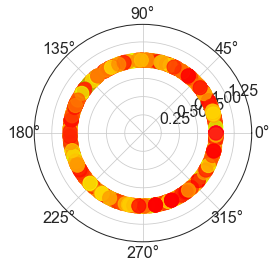

In [12]:
# look at the distribution on a unit circle. see if the distribution looks correct

colors = c_expect_filter['expect_theta_degree']
c_expect_filter['expect_newr'] = np.ones(c_expect_filter.expect_r.shape)
area = 200 * c_expect_filter['expect_newr']**2
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(c_expect_filter['expect_theta_degree'], c_expect_filter['expect_newr'], c=colors, s=area, cmap='hsv', alpha=0.75)


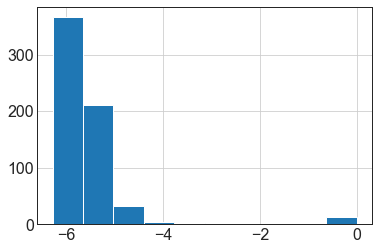

In [13]:
c_expect_filter['expect_theta_pi'].hist()

/Users/h/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


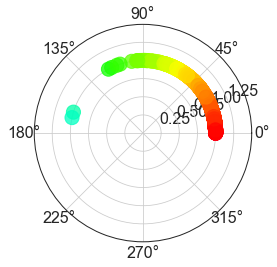

In [14]:
# look at the distribution on a unit circle. see if the distribution looks correct

colors = c_expect_filter['expect_theta_pi']
c_expect_filter['expect_newr'] = np.ones(c_expect_filter.expect_r.shape)
area = 200 * c_expect_filter['expect_newr']**2
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(c_expect_filter['expect_theta_pi'], c_expect_filter['expect_newr'], c=colors, s=area, cmap='hsv', alpha=0.75)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe57d6e8dd8>]],
      dtype=object)

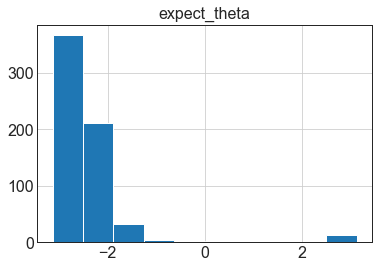

In [15]:
c_expect_filter.hist(column='expect_theta'
                    )

/Users/h/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


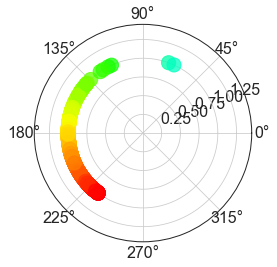

In [16]:
# look at the distribution on a unit circle. see if the distribution looks correct

colors = c_expect_filter['expect_theta_pi']
c_expect_filter['expect_newr'] = np.ones(c_expect_filter.expect_r.shape)
area = 200 * c_expect_filter['expect_newr']**2
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(c_expect_filter['expect_theta_flip'], c_expect_filter['expect_newr'], c=colors, s=area, cmap='hsv', alpha=0.75)


## expected rating - cue

### plot raw form

Text(0.5, 0.8, 'Cognitive task\n rating on semi-circular scale')

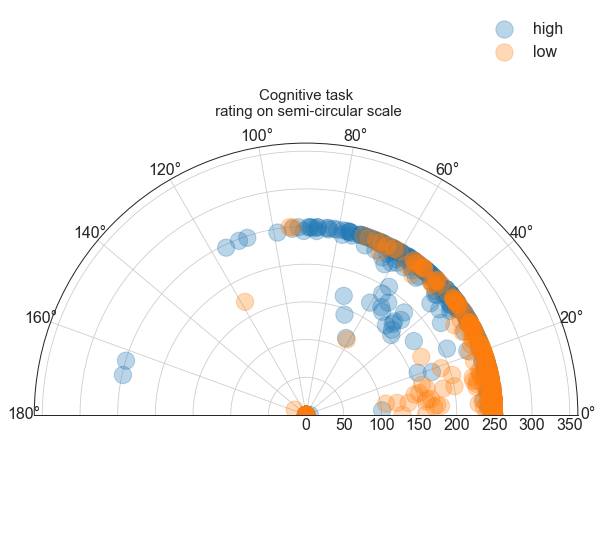

In [17]:
# c_result_dropna
# c_result 
colors = c_result['expect_theta_pi']
c_result['newr'] = np.ones(c_result.expect_r.shape)

area = 300 * c_result['newr']**2

c_groups = c_result.groupby('p2_cue_type')
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='polar')
ax.set_thetamin(0)
ax.set_thetamax(180)

for name, group in c_groups:
    ax.scatter(group.expect_theta_pi, group.expect_r,label=name, alpha=0.30, s=area, marker='o',cmap='hsv') 
ax.legend()

figure_title = "Cognitive task\n rating on semi-circular scale"
plt.text(0.5, 0.8, figure_title,
         horizontalalignment='center',
         fontsize=15,
         transform = ax.transAxes)


### plot by rotation degrees (assume equal r)

Text(0.5, 0.8, 'Cognitive task\n rating on semi-circular scale per degree')

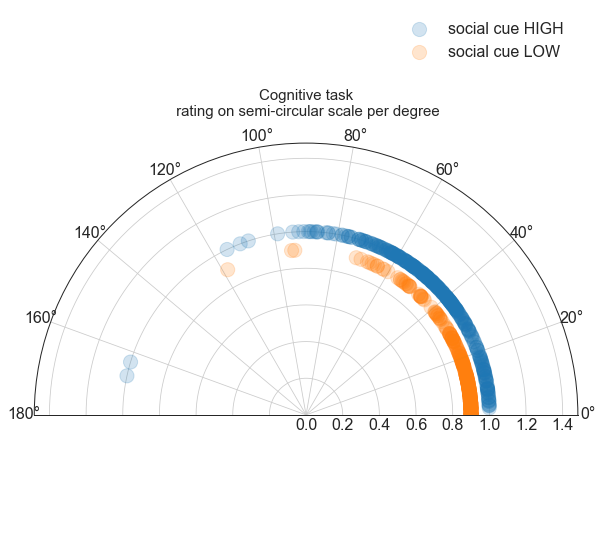

In [42]:
c_result['newr'] = np.ones(c_result.expect_r.shape)
area = 200 * c_result['newr']**2

# groups = result.groupby('administer')
cue_high = c_result[c_result['p2_cue_type'] =='high']
cue_low = c_result[c_result['p2_cue_type'] == 'low']


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='polar')
ax.set_thetamin(0)
ax.set_thetamax(180)
cuehigh = ax.scatter(cue_high.expect_theta_pi, np.ones(cue_high.newr.shape),label='social cue HIGH', alpha=0.20, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
cuelow  = ax.scatter(cue_low.expect_theta_pi, np.ones(cue_low.newr.shape)*0.9,label='social cue LOW', alpha=0.20, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
figure_title = "Cognitive task\n rating on semi-circular scale per degree"
plt.text(0.5, 0.8, figure_title,
         horizontalalignment='center',
         fontsize=15,
         transform = ax.transAxes)

### participant mean

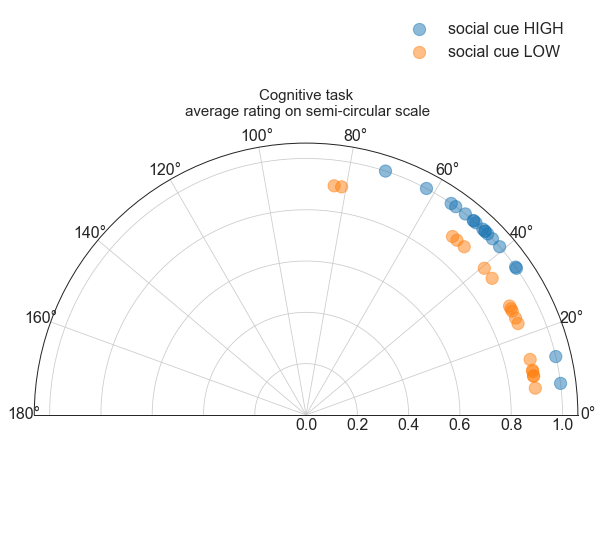

In [43]:
c_result = c_expect_filter
c_group_mean = c_result.groupby(['p2_cue_type','sub_num']).mean().reset_index()
colors = c_group_mean['expect_theta_pi']
c_group_mean['newr'] = np.ones(c_group_mean.expect_r.shape)
# area = 200 * c_result['newr']**2
area = 150 * c_group_mean['newr']**2


# groups = c_group_mean.groupby('administer')
c_group_mean_low = c_group_mean[c_group_mean['p2_cue_type'] =='low']
c_group_mean_high = c_group_mean[c_group_mean['p2_cue_type'] =='high']
# group_mean_150 = group_mean[group_mean['p5_administer_type'] ==150]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='polar')
ax.set_thetamin(0)
ax.set_thetamax(180)
# for name, group in groups:
#     ax.scatter(group.theta, group.newr_random,label=name, alpha=0.30, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
# ax.legend()
#  marker='o', linestyle='', ms=12,
figure_title = "Cognitive task\n average rating on semi-circular scale"
plt.text(0.5,0.8, figure_title,
         horizontalalignment='center',
         fontsize=15,
         transform = ax.transAxes)


chigh = ax.scatter(c_group_mean_high.expect_theta_pi, np.ones(c_group_mean_high.newr.shape),label='social cue HIGH', alpha=0.50, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
clow = ax.scatter(c_group_mean_low.expect_theta_pi, np.ones(c_group_mean_low.newr.shape)*0.9,label='social cue LOW', alpha=0.50, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 

# p150 = ax.scatter(group_mean_150.theta, np.ones(group_mean_150.newr.shape)*1.1,label=150, alpha=0.60, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
ax.legend()

## filter actual rating

In [44]:
c_actual_filter = c_result.loc[(c_result['actual_r']>=150) & (c_result['p6_actual_responseonset'] != "NA") ]


## actual rating - cue

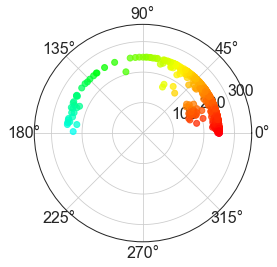

In [45]:
# Compute areas and colors
c_result = c_actual_filter
colors = c_result['actual_theta_pi']
# c_result['actual_newr'] = np.ones(c_result.expect_r.shape)
# area = 200 * c_result['actual_newr']**2
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(c_result['actual_theta_pi'], c_result['actual_r'], c=colors, cmap='hsv', alpha=0.75)


### plot raw form

Text(0.5, 0.8, 'Cognitive task\n rating on semi-circular scale')

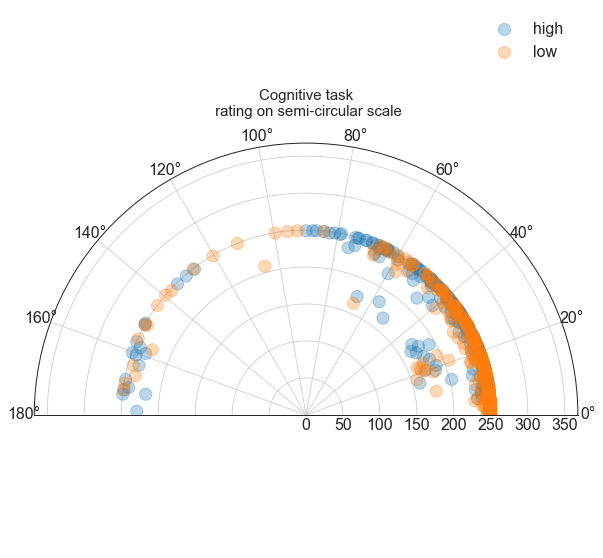

In [46]:

# area = 200 * result['newr']**2
# area = 200 * result['expect_newr']**2

groups = c_result.groupby('param_cue_type')
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='polar')
ax.set_thetamin(0)
ax.set_thetamax(180)

for name, group in groups:
    ax.scatter(group.actual_theta_pi, group.actual_r,label=name, alpha=0.30, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
ax.legend()

figure_title = "Cognitive task\n rating on semi-circular scale"
plt.text(0.5, 0.8, figure_title,
         horizontalalignment='center',
         fontsize=15,
         transform = ax.transAxes)

### plot by rotation degrees

/Users/h/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Text(0.5, 0.8, 'Cognitive task\n rating on semi-circular scale per degree')

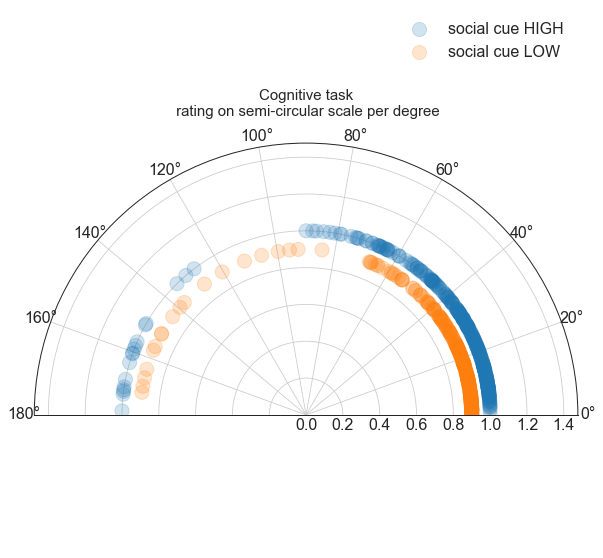

In [47]:
# Compute areas and colors

colors = c_result['actual_theta_pi']
c_result['newr'] = np.ones(c_result.actual_r.shape)

area = 200 * c_result['newr']**2

# groups = c_result.groupby('administer')
ca_group_low = c_result[c_result['param_cue_type'] =='low']
ca_group_high = c_result[c_result['param_cue_type'] =='high']

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='polar')
ax.set_thetamin(0)
ax.set_thetamax(180)
p100 = ax.scatter(ca_group_high.actual_theta_pi, np.ones(ca_group_high.actual_r.shape),label='social cue HIGH', alpha=0.20, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
p50 = ax.scatter(ca_group_low.actual_theta_pi, np.ones(ca_group_low.actual_r.shape)*0.9,label='social cue LOW', alpha=0.20, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
figure_title = "Cognitive task\n rating on semi-circular scale per degree"
plt.text(0.5, 0.8, figure_title,
         horizontalalignment='center',
         fontsize=15,
         transform = ax.transAxes)

### participant mean

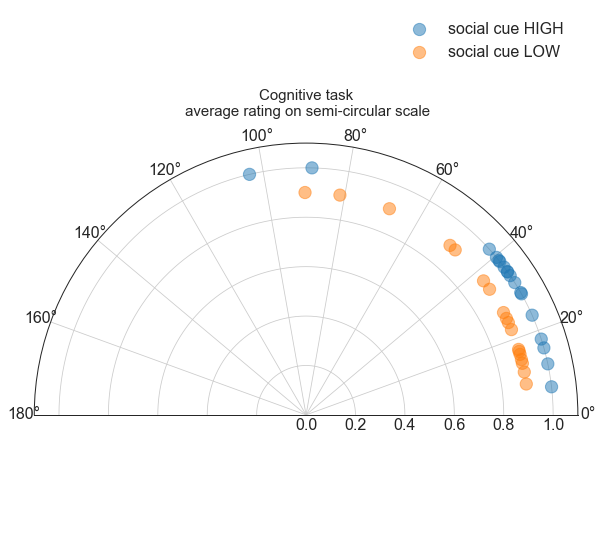

In [48]:
c_group_mean = c_result.groupby(['p2_cue_type','sub_num']).mean().reset_index()
colors = c_group_mean['actual_theta_pi']
c_group_mean['newr'] = np.ones(c_group_mean.expect_r.shape)
area = 150 * c_group_mean['newr']**2
c_group_mean_low = c_group_mean[c_group_mean['p2_cue_type'] =='low']
c_group_mean_high = c_group_mean[c_group_mean['p2_cue_type'] =='high']
fig = plt.figure(figsize=(10, 10));ax = fig.add_subplot(projection='polar');ax.set_thetamin(0);ax.set_thetamax(180)
figure_title = "Cognitive task\n average rating on semi-circular scale"
plt.text(0.5,0.8, figure_title,
         horizontalalignment='center',
         fontsize=15,
         transform = ax.transAxes)

chigh = ax.scatter(c_group_mean_high.actual_theta_pi, np.ones(c_group_mean_high.newr.shape),label='social cue HIGH', alpha=0.50, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
clow = ax.scatter(c_group_mean_low.actual_theta_pi, np.ones(c_group_mean_low.newr.shape)*0.9,label='social cue LOW', alpha=0.50, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 

# p150 = ax.scatter(group_mean_150.theta, np.ones(group_mean_150.newr.shape)*1.1,label=150, alpha=0.60, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
ax.legend()

## actual rating - levels

### raw form

Text(0.5, 0.8, 'Cognitive task\n rating on semi-circular scale')

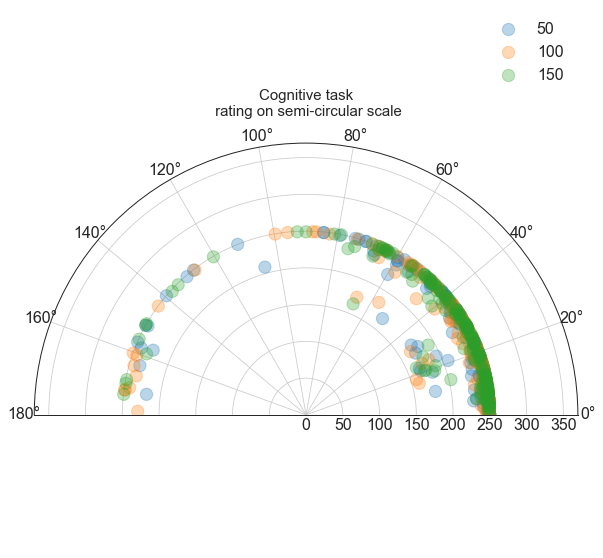

In [49]:
groups = c_result.groupby('param_administer_type')
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='polar')
ax.set_thetamin(0)
ax.set_thetamax(180)

for name, group in groups:
    ax.scatter(group.actual_theta_pi, group.actual_r,label=name, alpha=0.30, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
ax.legend()

figure_title = "Cognitive task\n rating on semi-circular scale"
plt.text(0.5, 0.8, figure_title,
         horizontalalignment='center',
         fontsize=15,
         transform = ax.transAxes)

### rotation degrees - ignore r

/Users/h/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0.8, 'Cognitive task\n rating on semi-circular scale per degree')

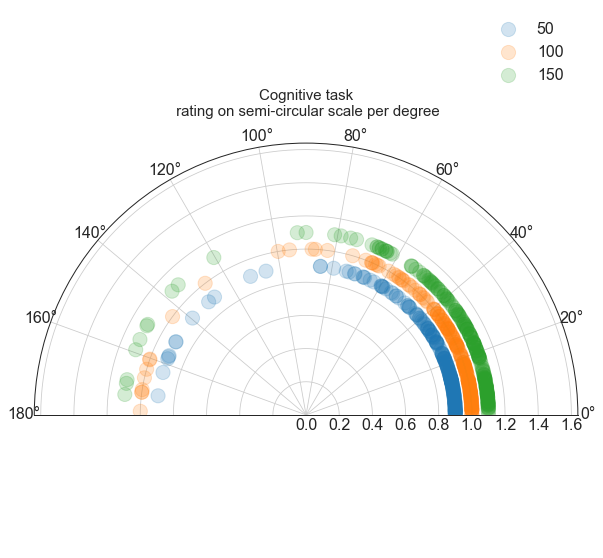

In [50]:
# Compute areas and colors
colors = c_result['actual_theta_pi']
c_result['newr'] = np.ones(c_result.actual_r.shape)

area = 200 * c_result['newr']**2

# groups = c_result.groupby('administer')
group50 = c_result[c_result['param_administer_type'] ==50]
group100 = c_result[c_result['param_administer_type'] ==100]
group150 = c_result[c_result['param_administer_type'] ==150]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='polar')
ax.set_thetamin(0)
ax.set_thetamax(180)
p50 = ax.scatter(group50.actual_theta_pi, np.ones(group50.actual_r.shape)*0.9,label=50, alpha=0.20, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
p100 = ax.scatter(group100.actual_theta_pi, np.ones(group100.actual_r.shape),label=100, alpha=0.20, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
p150 = ax.scatter(group150.actual_theta_pi, np.ones(group150.actual_r.shape)*1.1,label=150, alpha=0.20, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
figure_title = "Cognitive task\n rating on semi-circular scale per degree"
plt.text(0.5, 0.8, figure_title,
         horizontalalignment='center',
         fontsize=15,
         transform = ax.transAxes)

### subject-wise mean

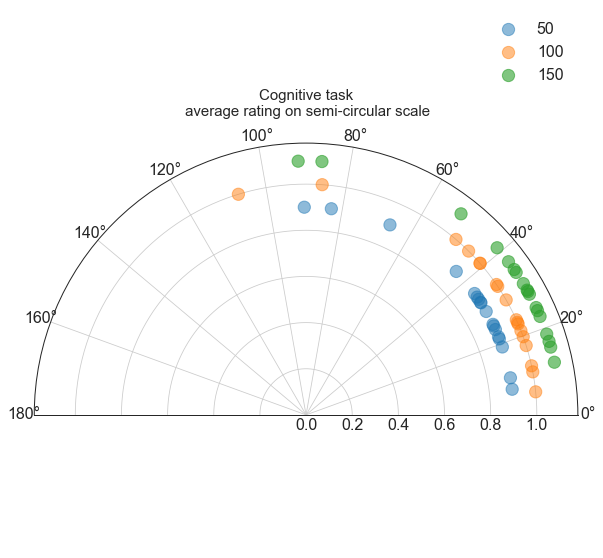

In [51]:
c_group_mean = c_result.groupby(['param_administer_type','sub_num']).mean().reset_index()
colors = c_group_mean['actual_theta_pi']
c_group_mean['newr'] = np.ones(c_group_mean.actual_r.shape)
# area = 200 * c_result['newr']**2
area = 150 * c_group_mean['newr']**2

actual_group_mean_50 = c_group_mean[c_group_mean['p5_administer_type'] ==50]
actual_group_mean_100 = c_group_mean[c_group_mean['p5_administer_type'] ==100]
actual_group_mean_150 = c_group_mean[c_group_mean['p5_administer_type'] ==150]
fig = plt.figure(figsize=(10, 10));ax = fig.add_subplot(projection='polar');ax.set_thetamin(0);ax.set_thetamax(180)

figure_title = "Cognitive task\n average rating on semi-circular scale"
plt.text(0.5,0.8, figure_title,
         horizontalalignment='center',
         fontsize=15,
         transform = ax.transAxes)

p50 = ax.scatter(actual_group_mean_50.actual_theta_pi, np.ones(actual_group_mean_50.newr.shape)*0.9,label=50, alpha=0.50, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
p100 = ax.scatter(actual_group_mean_100.actual_theta_pi, np.ones(actual_group_mean_100.newr.shape),label=100, alpha=0.50, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
p150 = ax.scatter(actual_group_mean_150.actual_theta_pi, np.ones(actual_group_mean_150.newr.shape)*1.1,label=150, alpha=0.60, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
ax.legend()

# [ Vicarious ]

## load data

In [56]:
sublist = [1,2,3,4,5,6,7,8,9,10,11,12,15,16,19,25,26,27,28]
main_dir = '/Users/h/Documents/projects_local/social_influence_analysis'

v_df = pd.DataFrame()
v_result = pd.DataFrame()

for ind,sub in enumerate(sublist):
    loadfilename =  os.path.join(main_dir , 'boulder', 'beh_withcoord', 
                                 'sub-' + str(('%04d' % sub)), 'sub-' + str(('%04d' % sub)) + '_task-vicarious_meta_beh.csv')
    v_df = pd.read_csv(loadfilename)
    v_df['sub_num'] = sub
    v_result = pd.concat([v_result, v_df], axis = 0, sort = True)

In [57]:
# step 3 - subtract mid point ________________________________________________________________________

v_result['new_expect_coord_x'] = (v_result['expect_ptb_coord_x'] - 512)
v_result['new_expect_coord_y'] = (v_result['expect_ptb_coord_y'] - 551)
v_result['new_actual_coord_x'] = (v_result['actual_ptb_coord_x'] - 512)
v_result['new_actual_coord_y'] = (v_result['actual_ptb_coord_y'] - 551)

v_result['expect_r'], v_result['expect_theta'] = cart2pol(v_result['new_expect_coord_x'], v_result['new_expect_coord_y'])
v_result['actual_r'], v_result['actual_theta'] = cart2pol(v_result['new_actual_coord_x'], v_result['new_actual_coord_y'])

In [58]:
# make sure to extract pi, otherwise, the thetas are flipped _____________________________________________________________________
v_result['expect_theta_pi'] = v_result['expect_theta']-np.pi
v_result['actual_theta_pi'] = v_result['actual_theta']-np.pi

In [60]:
v_result.head()

,Unnamed: 0,actual_ptb_coord_x,actual_ptb_coord_y,expect_ptb_coord_x,expect_ptb_coord_y,p1_fixation_duration,p1_fixation_onset,p2_cue_filename,p2_cue_onset,p2_cue_type,...,new_expect_coord_x,new_expect_coord_y,new_actual_coord_x,new_actual_coord_y,expect_r,expect_theta,actual_r,actual_theta,expect_theta_pi,actual_theta_pi
0,0,271,500,429,332,0.808867,13559.066245,h041.png,13559.907388,high,...,-83,-219,-241,-51,234.200769,-1.933065,246.337167,-2.933051,-5.074658,-6.074644
1,1,277,539,296,461,4.015578,13576.574215,l025.png,13580.622796,low,...,-216,-90,-235,-12,234.000000,-2.746802,235.306184,-3.090573,-5.888394,-6.232166
2,2,286,476,381,340,0.914306,13597.474272,h024.png,13598.405067,high,...,-131,-211,-226,-75,248.358612,-2.126408,238.119718,-2.821170,-5.268001,-5.962763
3,3,273,508,281,467,1.115578,13614.155288,l031.png,13615.287406,low,...,-231,-84,-239,-43,245.798698,-2.792822,242.837394,-2.963581,-5.934414,-6.105173
4,4,269,551,361,352,4.014837,13631.738548,h022.png,13635.786170,high,...,-151,-199,-243,0,249.803923,-2.219902,243.000000,3.141593,-5.361495,0.000000


In [61]:
# drop trials that don't have ratings (expect rating onset NA)
# drop trials that didn't reach the scale (basically centered around origin)
v_expect_filter = v_result.loc[(v_result['expect_r']>=150) & (v_result['p3_expect_responseonset'] != "NA") ]
v_actual_filter = v_result.loc[(v_result['actual_r']>=150) & (v_result['p6_actual_responseonset'] != "NA") ]


/Users/h/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/h/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


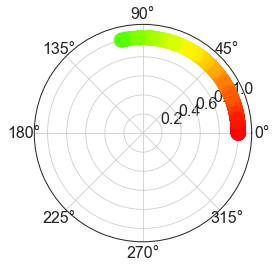

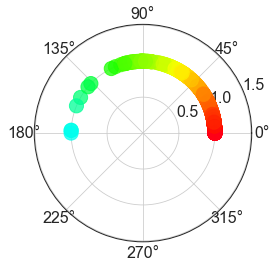

In [62]:
# look at the distribution on a unit circle. see if the distribution looks correct ______________________________
colors = v_expect_filter['expect_theta_pi']
v_expect_filter['expect_newr'] = np.ones(v_expect_filter.expect_r.shape)
area = 200 * v_expect_filter['expect_newr']**2
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(v_expect_filter['expect_theta_pi'], v_expect_filter['expect_newr'], c=colors, s=area, cmap='hsv', alpha=0.75)

colors = v_actual_filter['actual_theta_pi']
v_actual_filter['actual_newr'] = np.ones(v_actual_filter.actual_r.shape)
area = 200 * v_actual_filter['actual_newr']**2
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
a = ax.scatter(v_actual_filter['actual_theta_pi'], v_actual_filter['actual_newr'], c=colors, s=area, cmap='hsv', alpha=0.75)


## expected rating - cue

### plot raw form

Text(0.5, 0.8, 'Vicarious task\n rating on semi-circular scale')

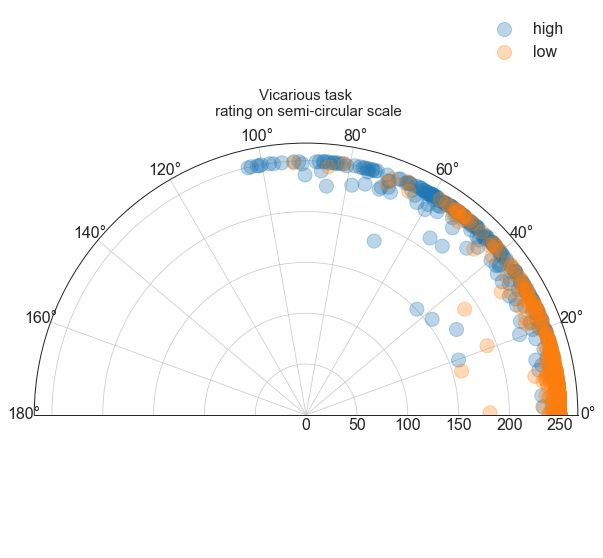

In [63]:
area = 200 * v_expect_filter['expect_newr']**2

v_groups = v_expect_filter.groupby('param_cue_type')
fig = plt.figure(figsize=(10, 10)); ax = fig.add_subplot(projection='polar');ax.set_thetamin(0);ax.set_thetamax(180)

for name, v_group in v_groups:
    ax.scatter(v_group.expect_theta_pi, v_group.expect_r,label=name, alpha=0.30, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
ax.legend()

figure_title = "Vicarious task\n rating on semi-circular scale"
plt.text(0.5, 0.8, figure_title,
         horizontalalignment='center',
         fontsize=15,
         transform = ax.transAxes)

### plot by rotation degrees

/Users/h/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0.5, 0.8, 'Vicarious task\n rating on semi-circular scale per degree')

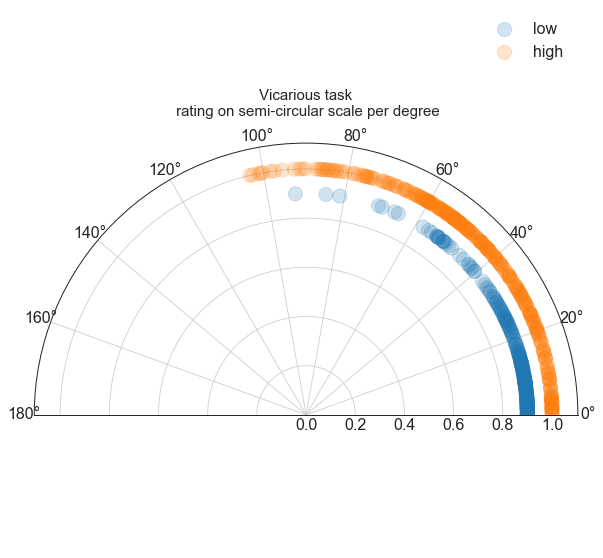

In [64]:
colors = v_expect_filter['expect_theta_pi']
v_expect_filter['newr'] = np.ones(v_expect_filter.expect_r.shape)
area = 200 * v_expect_filter['newr']**2

v_group_low = v_expect_filter[v_expect_filter['param_cue_type'] == 'low']
v_group_high = v_expect_filter[v_expect_filter['param_cue_type'] == 'high']

fig = plt.figure(figsize=(10, 10));ax = fig.add_subplot(projection='polar');ax.set_thetamin(0);ax.set_thetamax(180)
v_low = ax.scatter(v_group_low.expect_theta_pi, np.ones(v_group_low.newr.shape)*0.9,label='low', alpha=0.20, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
p100 = ax.scatter(v_group_high.expect_theta_pi, np.ones(v_group_high.newr.shape),label='high', alpha=0.20, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
figure_title = "Vicarious task\n rating on semi-circular scale per degree"
plt.text(0.5, 0.8, figure_title,
         horizontalalignment='center',
         fontsize=15,
         transform = ax.transAxes)

### participant mean

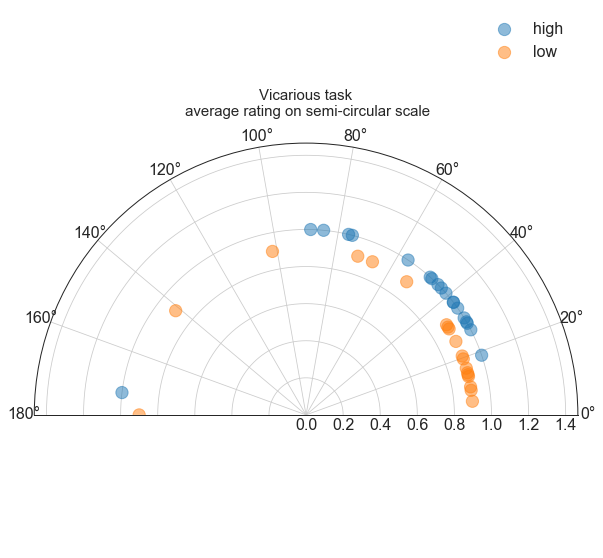

In [182]:
v_group_mean = v_result.groupby(['param_cue_type','sub_num']).mean().reset_index()
colors = v_group_mean['expect_theta_pi']
v_group_mean['newr'] = np.ones(v_group_mean.expect_r.shape)
area = 150 * v_group_mean['newr']**2

v_group_mean_low = v_group_mean[v_group_mean['param_cue_type'] == 'low']
v_group_mean_high = v_group_mean[v_group_mean['param_cue_type'] =='high']
fig = plt.figure(figsize=(10, 10));ax = fig.add_subplot(projection='polar');ax.set_thetamin(0);ax.set_thetamax(180)

figure_title = "Vicarious task\n average rating on semi-circular scale"
plt.text(0.5,0.8, figure_title,
         horizontalalignment='center',
         fontsize=15,
         transform = ax.transAxes)

plot_VexH = ax.scatter(v_group_mean_high.expect_theta_pi, np.ones(v_group_mean_high.newr.shape),label='high', alpha=0.50, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
plot_VexL = ax.scatter(v_group_mean_low.expect_theta_pi, np.ones(v_group_mean_low.newr.shape)*0.9,label='low', alpha=0.50, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 

ax.legend()

## actual rating - cue

### plot raw form

Text(0.5, 0.8, 'Vicarious task\n Actual rating on semi-circular scale')

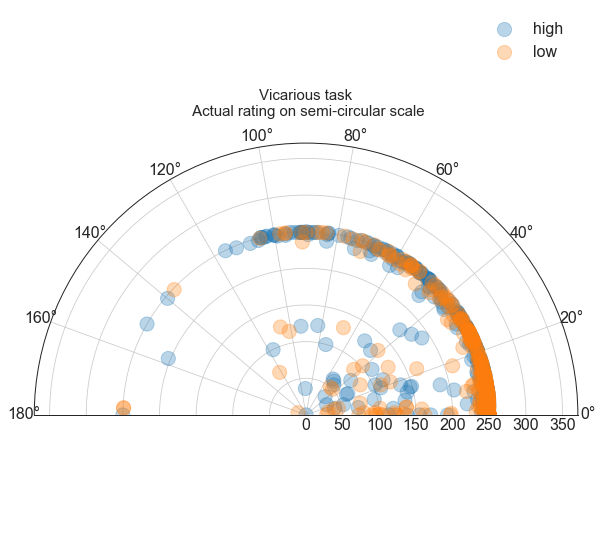

In [183]:
v_result['actual_newr'] = np.ones(v_result.actual_r.shape)
area = 200 * v_result['actual_newr']**2

v_groups = v_result.groupby('param_cue_type')
fig = plt.figure(figsize=(10, 10)); ax = fig.add_subplot(projection='polar');ax.set_thetamin(0);ax.set_thetamax(180)

for name, v_group in v_groups:
    ax.scatter(v_group.actual_theta_pi, v_group.actual_r,label=name, alpha=0.30, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
ax.legend()

figure_title = "Vicarious task\n Actual rating on semi-circular scale"
plt.text(0.5, 0.8, figure_title,
         horizontalalignment='center',
         fontsize=15,
         transform = ax.transAxes)

### plot by rotation degrees

Text(0.5, 0.8, 'Vicarious task\n Actual rating on semi-circular scale per degree')

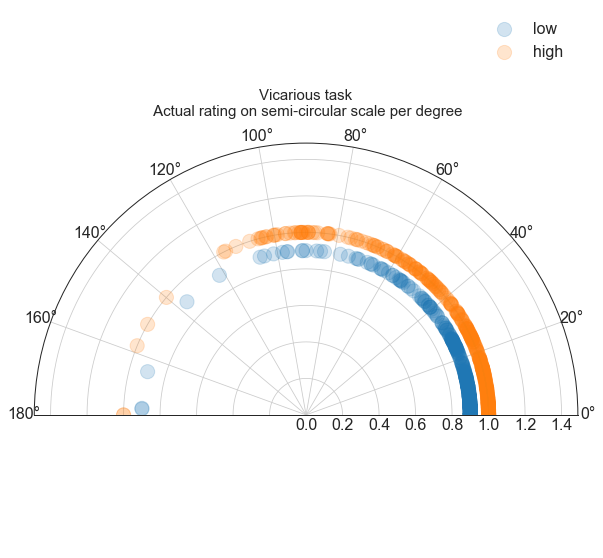

In [185]:
colors = v_result['actual_theta_pi']
area = 200 * v_result['actual_newr']**2

v_group_low = v_result[v_result['param_cue_type'] == 'low']
v_group_high = v_result[v_result['param_cue_type'] == 'high']

fig = plt.figure(figsize=(10, 10));ax = fig.add_subplot(projection='polar');ax.set_thetamin(0);ax.set_thetamax(180)
VacL = ax.scatter(v_group_low.actual_theta_pi, np.ones(v_group_low.actual_newr.shape)*0.9,label='low', alpha=0.20, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
VacH = ax.scatter(v_group_high.actual_theta_pi, np.ones(v_group_high.actual_newr.shape),label='high', alpha=0.20, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
figure_title = "Vicarious task\n Actual rating on semi-circular scale per degree"
plt.text(0.5, 0.8, figure_title,
         horizontalalignment='center',
         fontsize=15,
         transform = ax.transAxes)

### participant mean

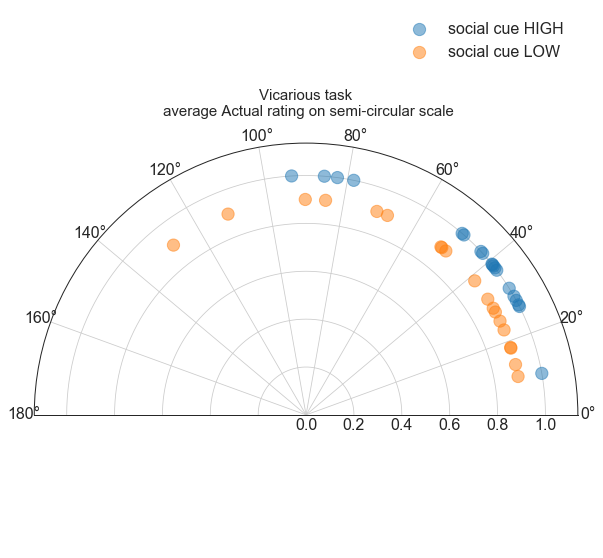

In [186]:
v_group_mean = v_result.groupby(['p2_cue_type','sub_num']).mean().reset_index()
colors = v_group_mean['actual_theta_pi']
v_group_mean['newr'] = np.ones(v_group_mean.actual_r.shape)
area = 150 * v_group_mean['newr']**2
v_group_mean_low = v_group_mean[v_group_mean['p2_cue_type'] =='low']
v_group_mean_high = v_group_mean[v_group_mean['p2_cue_type'] =='high']
fig = plt.figure(figsize=(10, 10));ax = fig.add_subplot(projection='polar');ax.set_thetamin(0);ax.set_thetamax(180)
figure_title = "Vicarious task\n average Actual rating on semi-circular scale"
plt.text(0.5,0.8, figure_title,
         horizontalalignment='center',
         fontsize=15,
         transform = ax.transAxes)

VacH = ax.scatter(v_group_mean_high.actual_theta_pi, np.ones(v_group_mean_high.newr.shape),label='social cue HIGH', alpha=0.50, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
VacL = ax.scatter(v_group_mean_low.actual_theta_pi, np.ones(v_group_mean_low.newr.shape)*0.9,label='social cue LOW', alpha=0.50, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 

# p150 = ax.scatter(group_mean_150.theta, np.ones(group_mean_150.newr.shape)*1.1,label=150, alpha=0.60, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
ax.legend()

## actual rating - levels

### plot raw form

Text(0.5, 0.8, 'Cognitive task\n rating on semi-circular scale')

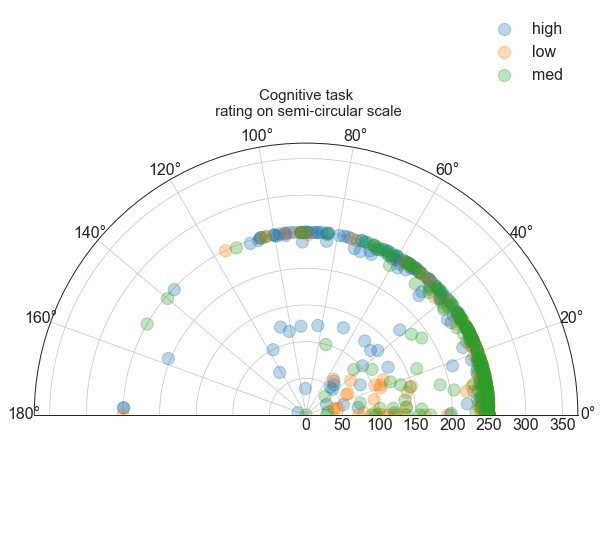

In [187]:
v_groups = v_result.groupby('param_administer_type')
fig = plt.figure(figsize=(10, 10));ax = fig.add_subplot(projection='polar');ax.set_thetamin(0);ax.set_thetamax(180)

for name, vgroup in v_groups:
    ax.scatter(vgroup.actual_theta_pi, vgroup.actual_r,label=name, alpha=0.30, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
ax.legend()

figure_title = "Cognitive task\n rating on semi-circular scale"
plt.text(0.5, 0.8, figure_title,
         horizontalalignment='center',
         fontsize=15,
         transform = ax.transAxes)

### rotation degrees - ignore r

Text(0.5, 0.8, 'Vicarious task\n Actual rating on 3 levels semi-circular scale per degree')

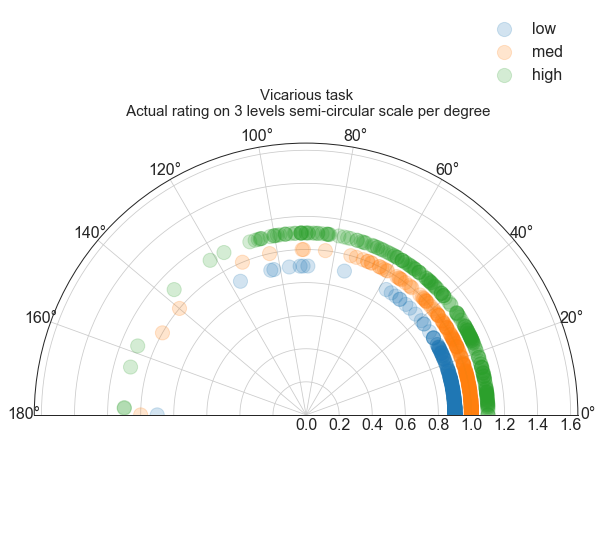

In [190]:
# Compute areas and colors
colors = v_result['actual_theta_pi']
v_result['newr'] = np.ones(v_result.actual_r.shape)

area = 200 * c_result['newr']**2

# groups = c_result.groupby('administer')
groupL = v_result[v_result['param_administer_type'] =='low']
groupM= v_result[v_result['param_administer_type'] =='med']
groupH = v_result[v_result['param_administer_type'] =='high']

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='polar')
ax.set_thetamin(0)
ax.set_thetamax(180)
pVacL = ax.scatter(groupL.actual_theta_pi, np.ones(groupL.actual_r.shape)*0.9,label='low', alpha=0.20, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
pVacM = ax.scatter(groupM.actual_theta_pi, np.ones(groupM.actual_r.shape),label='med', alpha=0.20, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
pVacH = ax.scatter(groupH.actual_theta_pi, np.ones(groupH.actual_r.shape)*1.1,label='high', alpha=0.20, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
figure_title = "Vicarious task\n Actual rating on 3 levels semi-circular scale per degree"
plt.text(0.5, 0.8, figure_title,
         horizontalalignment='center',
         fontsize=15,
         transform = ax.transAxes)

### subject-wise mean

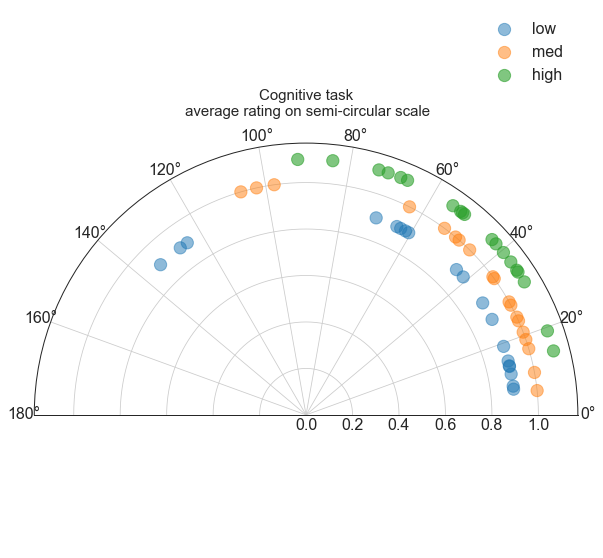

In [191]:
v_group_mean = v_result.groupby(['param_administer_type','sub_num']).mean().reset_index()
colors = v_group_mean['actual_theta_pi']
v_group_mean['newr'] = np.ones(v_group_mean.actual_r.shape)
# area = 200 * c_result['newr']**2
area = 150 * v_group_mean['newr']**2

actual_group_mean_L = v_group_mean[v_group_mean['param_administer_type'] == 'low']
actual_group_mean_M = v_group_mean[v_group_mean['param_administer_type'] == 'med']
actual_group_mean_H = v_group_mean[v_group_mean['param_administer_type'] == 'high']
fig = plt.figure(figsize=(10, 10));ax = fig.add_subplot(projection='polar');ax.set_thetamin(0);ax.set_thetamax(180)

figure_title = "Cognitive task\n average rating on semi-circular scale"
plt.text(0.5,0.8, figure_title,
         horizontalalignment='center',
         fontsize=15,
         transform = ax.transAxes)

pVacLmean = ax.scatter(actual_group_mean_L.actual_theta_pi, np.ones(actual_group_mean_L.newr.shape)*0.9,label='low', alpha=0.50, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
pVacMmean = ax.scatter(actual_group_mean_M.actual_theta_pi, np.ones(actual_group_mean_M.newr.shape),label='med', alpha=0.50, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
pVacHmean = ax.scatter(actual_group_mean_H.actual_theta_pi, np.ones(actual_group_mean_H.newr.shape)*1.1,label='high', alpha=0.60, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
ax.legend()